In [16]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt


np.random.seed(1234)
tf.random.set_seed(1234)
tf.config.list_physical_devices('GPU')

[]

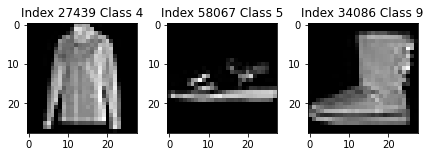

In [17]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [18]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [19]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [10]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = len(set(y_train))

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# MLP with pre-activation BN -- g(BN(f(x)))# 

In [21]:
# Define class to build mlp model
class BNMLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2,size_output, device=None,\
                 regularizer=None, R_lambda = 1e-4, drop_prob=0):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
        """
        self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
        size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
        self.regularizer, self.R_lambda, self.drop_prob = regularizer, R_lambda, drop_prob

        # Initialize weights between input mapping and a layer g(f(x)) = layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
        # Initialize biases for hidden layer
        self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)

        # Initialize weights between input layer and 1st hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
        # Initialize biases for hidden layer
        self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

        # Initialize weights between 1st hidden layer and 2nd hidden layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
        # Initialize biases for hidden layer
        self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))

         # Initialize weights between 2nd hidden layer and output layer
        self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
        # Initialize biases for output layer
        self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
             
        # Initialize BN scale parameter in the input layer
        self.gamma0 = tf.Variable(tf.random.normal([1,self.size_input],stddev=0.1))
        self.beta0 = tf.Variable(tf.zeros([1, self.size_input]))
        self.batch_mean0 = tf.Variable(tf.zeros([1, self.size_input]))
        self.batch_var0 = tf.Variable(tf.ones([1, self.size_input]))
        
        # Initialize BN scale parameter in the hidden layer 1
        self.gamma1 = tf.Variable(tf.random.normal([1,self.size_hidden1],stddev=0.1))
        self.beta1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
        self.batch_mean1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
        self.batch_var1 = tf.Variable(tf.ones([1, self.size_hidden1]))
        
        # Initialize BN scale parameter in the hidden layer 2
        self.gamma2 = tf.Variable(tf.random.normal([1,self.size_hidden2],stddev=0.1))
        self.beta2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
        self.batch_mean2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
        self.batch_var2 = tf.Variable(tf.ones([1, self.size_hidden2]))
        
        # Initialize BN scale parameter in the hidden layer 3
        self.gamma3 = tf.Variable(tf.random.normal([1,self.size_hidden3],stddev=0.1))
        self.beta3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
        self.batch_mean3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
        self.batch_var3 = tf.Variable(tf.ones([1, self.size_hidden3]))
        
        self.momentum=0.9

        # Define variables to be updated during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4,\
                         self.gamma0, self.gamma1, self.gamma2, self.gamma3, self.beta0, self.beta1, self.beta2, self.beta3]
        
    def forward(self, X, mode=0):
        """
        forward pass
        X: Tensor, inputs
        mode=0: training, mode=1: inference
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)

        return self.y

    def loss(self, y_pred, y_true):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''  
        #cross entropy loss for classifation mission
        return tf.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits = True)
        #return tf.reduce_sum(-tf.math.log(tf.boolean_mask(y_pred, tf.one_hot(y_true, depth=y_pred.shape[-1]))))/y_pred.shape[0]

    def backward(self, X_train, y_train, hyperparams, method='sgd'):
        """
        backward pass
        """
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train, mode=0)
            current_loss = self.loss(predicted, y_train)
            
            num_layer = 3
            if not self.regularizer:
                current_loss = self.loss(predicted, y_train)
            elif self.regularizer == 'l2':
                #flatten shape
                w = tf.concat([tf.reshape(w,[-1]) for w in self.variables[:num_layer]],0)
                current_loss  += self.R_lambda * tf.nn.l2_loss(w)
            elif self.regularizer == 'l1':
                #flatten shape
                w = tf.concat([tf.reshape(w,[-1]) for w in self.variables[:num_layer]],0)
                current_loss  += self.R_lambda * tf.nn.l1_loss(w)
            
        grads = tape.gradient(current_loss, self.variables)
        
        if method == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate = hyperparams['lr'])
            optimizer.apply_gradients(zip(grads, self.variables))

    def compute_output(self, X, mode=0):
        """
        Custom method to obtain output tensor during forward pass
        """
        epsilon=1e-6
        X_tf = tf.cast(X, dtype=tf.float32)
        # Cast X to float32
        
        
        ##BN in input layer
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean0 = tf.math.reduce_mean(X_tf, axis=0)
            sample_var0 = tf.math.reduce_variance(X_tf, axis=0)
            now_normalize0 = (X_tf - sample_mean0) / tf.sqrt(sample_var0+epsilon) # should be broadcastable..
            X_tf = self.gamma0 * now_normalize0 + self.beta0
            #update batch mean and variance
            self.batch_mean0 = self.momentum * self.batch_mean0 + (1.0-self.momentum) * sample_mean0
            self.batch_var0 = self.momentum * self.batch_var0 + (1.0-self.momentum)*sample_var0
        else:
            X_tf = self.gamma0 * (X_tf - self.batch_mean0) / tf.sqrt(self.batch_var0+epsilon) + self.beta0
        

        # Compute values in hidden layers
        z1 = tf.matmul(X_tf, self.W1) + self.b1
        
        #BN in hidden layer 1
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean1 = tf.math.reduce_mean(z1, axis=0)
            sample_var1 = tf.math.reduce_variance(z1, axis=0)
            now_normalize1 = (z1 - sample_mean1) / tf.sqrt(sample_var1+epsilon) # should be broadcastable..
            z1 = self.gamma1 * now_normalize1 + self.beta1
            #update batch mean and variance
            self.batch_mean1 = self.momentum * self.batch_mean1 + (1.0-self.momentum) * sample_mean1
            self.batch_var1 = self.momentum * self.batch_var1 + (1.0-self.momentum)*sample_var1
        else:
            z1 = self.gamma1 * (z1 - self.batch_mean1) / tf.sqrt(self.batch_var1+epsilon) + self.beta1
            
        h1 = tf.nn.relu(z1)

        z2 = tf.matmul(h1, self.W2) + self.b2
        
        #BN in hidden layer 2
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean2 = tf.math.reduce_mean(z2, axis=0)
            sample_var2 = tf.math.reduce_variance(z2, axis=0)
            now_normalize2 = (z2 - sample_mean2) / tf.sqrt(sample_var2+epsilon) # should be broadcastable..
            z2 = self.gamma2 * now_normalize2 + self.beta2
            #update batch mean and variance
            self.batch_mean2 = self.momentum * self.batch_mean2 + (1.0-self.momentum) * sample_mean2
            self.batch_var2 = self.momentum * self.batch_var2 + (1.0-self.momentum)*sample_var2
        else:
            z2 = self.gamma2 * (z2 - self.batch_mean2) / tf.sqrt(self.batch_var2+epsilon) + self.beta2
        h2 = tf.nn.relu(z2)

        z3 = tf.matmul(h2, self.W3) + self.b3
        
        #BN in hidden layer 3
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean3 = tf.math.reduce_mean(z3, axis=0)
            sample_var3 = tf.math.reduce_variance(z3, axis=0)
            now_normalize3 = (z3 - sample_mean3) / tf.sqrt(sample_var3+epsilon) # should be broadcastable..
            z3 = self.gamma3 * now_normalize3 + self.beta3
            #update batch mean and variance
            self.batch_mean3 = self.momentum * self.batch_mean3 + (1.0-self.momentum) * sample_mean3
            self.batch_var3 = self.momentum * self.batch_var3 + (1.0-self.momentum)*sample_var3
        else:
            z3 = self.gamma3 * (z3 - self.batch_mean3) / tf.sqrt(self.batch_var3+epsilon) + self.beta3
        h3 = tf.nn.relu(z3)

        # Compute output
        z4 = tf.matmul(h3, self.W4) + self.b4
        output = tf.nn.softmax(z4)

        #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
        # Second add tf.Softmax(output) and then return this variable
        return (output)
    
    def accuracy(self,y_pred, y_true):
        """
        compute the correct num
        y_pred: the probability distribution [[...]] or the predicted label [...]
        y_true: the 1-D true label
        """
        #detect if y_pred is a probability distribution 
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            y_pred = tf.argmax(y_pred, axis=1)
            
        cmp = tf.cast(y_pred, y_true.dtype) == y_true
        
        return float(tf.reduce_sum(tf.cast(cmp, tf.int32)))

    #  def stderr(self,y_pred):
    #     """
    #      Calculate standard error
    #      """
    #     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #     std_dev = np.std(y_pred_tf) #Calculates standard deviation
    #     std_err = std_dev/sqrt(len(y_pred_tf))
    #     return std_err 


    #  def var(self,y_pred):
    #     """
    #      Calculate variance 
    #      """
    #     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #     std_dev = np.std(y_pred_tf) #Calculates standard deviation
    #     variance = (std_dev**2) # calculate variance
    #     return variance 

In [22]:

# Set number of simulations and epochs
NUM_SIM = 3
NUM_EPOCHS = 100

for num_sim in range(NUM_SIM):
    np.random.seed(num_sim)
    tf.random.set_seed(num_sim)
    '''
    Initialize model using GPU or load an exitsing MLP
    '''
    BN_MLP = BNMLP(size_input, size_hidden1, size_hidden2, size_output, device='GPU',\
                regularizer=None, R_lambda = 1e-4, drop_prob=0.)

    time_start = time.time()
    hyperparams = {'t':1, 'lr':1e-4}

    for epoch in range(NUM_EPOCHS):
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*num_sim).batch(128)

        for inputs, outputs in train_ds:
            preds = BN_MLP.forward(inputs, mode = 0)

            #use SGD to train the model
            BN_MLP.backward(inputs, outputs, hyperparams,'sgd')
            hyperparams['t'] += 1
        
        if (epoch + 1)%10 == 0:
            #compute the result for the current epoch
            logits = BN_MLP.forward(X_train, mode = 1)
            train_loss = np.sum(BN_MLP.loss(logits, y_train))/len(y_train)
            train_acc = BN_MLP.accuracy(logits,y_train)/len(y_train)

            logits = BN_MLP.forward(X_val, mode = 1)
            val_loss = np.sum(BN_MLP.loss(logits, y_val))/len(y_val)
            val_acc = BN_MLP.accuracy(logits,y_val)/len(y_val)
            
            logits = BN_MLP.forward(X_test, mode = 1)
            test_loss = np.sum(BN_MLP.loss(logits, y_test))/len(y_test)
            test_acc = BN_MLP.accuracy(logits,y_test)/len(y_test)
            
            print('Number of Simulation = {} - Number of Epoch = {}'.format(num_sim+1, epoch + 1))
            print('Train loss:= {:.4f} - Val loss: {:.4f} - Test loss: {:.4f} - Train acc:= {:.2%} - Val acc:= {:.2%} - Test acc:= {:.2%}'\
                  .format(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc))
            
    time_taken = time.time() - time_start 
    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Simulation = 1 - Number of Epoch = 10
Train loss:= 2.0055 - Val loss: 2.0110 - Test loss: 2.0069 - Train acc:= 52.14% - Val acc:= 52.20% - Test acc:= 52.17%
Number of Simulation = 1 - Number of Epoch = 20
Train loss:= 1.7025 - Val loss: 1.7039 - Test loss: 1.7098 - Train acc:= 79.03% - Val acc:= 79.05% - Test acc:= 78.06%
Number of Simulation = 1 - Number of Epoch = 30
Train loss:= 1.6589 - Val loss: 1.6636 - Test loss: 1.6708 - Train acc:= 81.39% - Val acc:= 80.77% - Test acc:= 79.96%
Number of Simulation = 1 - Number of Epoch = 40
Train loss:= 1.6453 - Val loss: 1.6526 - Test loss: 1.6586 - Train acc:= 82.34% - Val acc:= 81.40% - Test acc:= 80.84%
Number of Simulation = 1 - Number of Epoch = 50
Train loss:= 1.6372 - Val loss: 1.6468 - Test loss: 1.6526 - Train acc:= 82.90% - Val acc:= 81.78% - Test acc:= 81.29%
Number of Simulation = 1 - Number of Epoch = 60
Train loss:= 1.6300 - Val loss: 1.6419 - Test loss: 1.6477 - Train acc:= 83.36% - Val acc:= 81.88% - Test acc:= 81.61

# MLP with post-activation BN -- BN(g(f(x)))#

In [23]:
# Define class to build mlp model
class BNMLP(object):
    def __init__(self, size_input, size_hidden1, size_hidden2,size_output, device=None,\
                 regularizer=None, R_lambda = 1e-4, drop_prob=0):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
        """
        self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
        size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
        self.regularizer, self.R_lambda, self.drop_prob = regularizer, R_lambda, drop_prob

        # Initialize weights between input mapping and a layer g(f(x)) = layer
        self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
        # Initialize biases for hidden layer
        self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)

        # Initialize weights between input layer and 1st hidden layer
        self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
        # Initialize biases for hidden layer
        self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

        # Initialize weights between 1st hidden layer and 2nd hidden layer
        self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
        # Initialize biases for hidden layer
        self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))

         # Initialize weights between 2nd hidden layer and output layer
        self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
        # Initialize biases for output layer
        self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
             
        # Initialize BN scale parameter in the input layer
        self.gamma0 = tf.Variable(tf.random.normal([1,self.size_input],stddev=0.1))
        self.beta0 = tf.Variable(tf.zeros([1, self.size_input]))
        self.batch_mean0 = tf.Variable(tf.zeros([1, self.size_input]))
        self.batch_var0 = tf.Variable(tf.ones([1, self.size_input]))
        
        # Initialize BN scale parameter in the hidden layer 1
        self.gamma1 = tf.Variable(tf.random.normal([1,self.size_hidden1],stddev=0.1))
        self.beta1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
        self.batch_mean1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
        self.batch_var1 = tf.Variable(tf.ones([1, self.size_hidden1]))
        
        # Initialize BN scale parameter in the hidden layer 2
        self.gamma2 = tf.Variable(tf.random.normal([1,self.size_hidden2],stddev=0.1))
        self.beta2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
        self.batch_mean2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
        self.batch_var2 = tf.Variable(tf.ones([1, self.size_hidden2]))
        
        # Initialize BN scale parameter in the hidden layer 3
        self.gamma3 = tf.Variable(tf.random.normal([1,self.size_hidden3],stddev=0.1))
        self.beta3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
        self.batch_mean3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
        self.batch_var3 = tf.Variable(tf.ones([1, self.size_hidden3]))
        
        self.momentum=0.9

        # Define variables to be updated during backpropagation
        self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4,\
                         self.gamma0, self.gamma1, self.gamma2, self.gamma3, self.beta0, self.beta1, self.beta2, self.beta3]
        
    def forward(self, X, mode=0):
        """
        forward pass
        X: Tensor, inputs
        mode=0: training, mode=1: inference
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)

        return self.y

    def loss(self, y_pred, y_true):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''  
        #cross entropy loss for classifation mission
        return tf.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits = True)
        #return tf.reduce_sum(-tf.math.log(tf.boolean_mask(y_pred, tf.one_hot(y_true, depth=y_pred.shape[-1]))))/y_pred.shape[0]

    def backward(self, X_train, y_train, hyperparams, method='sgd'):
        """
        backward pass
        """
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train, mode=0)
            current_loss = self.loss(predicted, y_train)
            
            num_layer = 3
            if not self.regularizer:
                current_loss = self.loss(predicted, y_train)
            elif self.regularizer == 'l2':
                #flatten shape
                w = tf.concat([tf.reshape(w,[-1]) for w in self.variables[:num_layer]],0)
                current_loss  += self.R_lambda * tf.nn.l2_loss(w)
            elif self.regularizer == 'l1':
                #flatten shape
                w = tf.concat([tf.reshape(w,[-1]) for w in self.variables[:num_layer]],0)
                current_loss  += self.R_lambda * tf.nn.l1_loss(w)
            
        grads = tape.gradient(current_loss, self.variables)
        
        if method == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate = hyperparams['lr'])
            optimizer.apply_gradients(zip(grads, self.variables))

    def compute_output(self, X, mode=0):
        """
        Custom method to obtain output tensor during forward pass
        """
        epsilon=1e-6
        X_tf = tf.cast(X, dtype=tf.float32)
        # Cast X to float32
        
        
        ##BN in input layer
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean0 = tf.math.reduce_mean(X_tf, axis=0)
            sample_var0 = tf.math.reduce_variance(X_tf, axis=0)
            now_normalize0 = (X_tf - sample_mean0) / tf.sqrt(sample_var0+epsilon) # should be broadcastable..
            X_tf = self.gamma0 * now_normalize0 + self.beta0
            #update batch mean and variance
            self.batch_mean0 = self.momentum * self.batch_mean0 + (1.0-self.momentum) * sample_mean0
            self.batch_var0 = self.momentum * self.batch_var0 + (1.0-self.momentum)*sample_var0
        else:
            X_tf = self.gamma0 * (X_tf - self.batch_mean0) / tf.sqrt(self.batch_var0+epsilon) + self.beta0
        

        # Compute values in hidden layers
        z1 = tf.matmul(X_tf, self.W1) + self.b1
        
        h1 = tf.nn.relu(z1)
        
        #BN in hidden layer 1
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean1 = tf.math.reduce_mean(h1, axis=0)
            sample_var1 = tf.math.reduce_variance(h1, axis=0)
            now_normalize1 = (h1 - sample_mean1) / tf.sqrt(sample_var1+epsilon) # should be broadcastable..
            h1 = self.gamma1 * now_normalize1 + self.beta1
            #update batch mean and variance
            self.batch_mean1 = self.momentum * self.batch_mean1 + (1.0-self.momentum) * sample_mean1
            self.batch_var1 = self.momentum * self.batch_var1 + (1.0-self.momentum)*sample_var1
        else:
            h1 = self.gamma1 * (h1 - self.batch_mean1) / tf.sqrt(self.batch_var1+epsilon) + self.beta1
            
        

        z2 = tf.matmul(h1, self.W2) + self.b2
        h2 = tf.nn.relu(z2)
        #BN in hidden layer 2
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean2 = tf.math.reduce_mean(h2, axis=0)
            sample_var2 = tf.math.reduce_variance(h2, axis=0)
            now_normalize2 = (h2 - sample_mean2) / tf.sqrt(sample_var2+epsilon) # should be broadcastable..
            h2 = self.gamma2 * now_normalize2 + self.beta2
            #update batch mean and variance
            self.batch_mean2 = self.momentum * self.batch_mean2 + (1.0-self.momentum) * sample_mean2
            self.batch_var2 = self.momentum * self.batch_var2 + (1.0-self.momentum)*sample_var2
        else:
            h2 = self.gamma2 * (h2 - self.batch_mean2) / tf.sqrt(self.batch_var2+epsilon) + self.beta2
        

        z3 = tf.matmul(h2, self.W3) + self.b3
        h3 = tf.nn.relu(z3)
        #BN in hidden layer 3
        #training mode
        if mode==0:
            # compute the sample_mean and sample_var for current batch
            sample_mean3 = tf.math.reduce_mean(h3, axis=0)
            sample_var3 = tf.math.reduce_variance(h3, axis=0)
            now_normalize3 = (h3 - sample_mean3) / tf.sqrt(sample_var3+epsilon) # should be broadcastable..
            h3 = self.gamma3 * now_normalize3 + self.beta3
            #update batch mean and variance
            self.batch_mean3 = self.momentum * self.batch_mean3 + (1.0-self.momentum) * sample_mean3
            self.batch_var3 = self.momentum * self.batch_var3 + (1.0-self.momentum)*sample_var3
        else:
            h3 = self.gamma3 * (h3 - self.batch_mean3) / tf.sqrt(self.batch_var3+epsilon) + self.beta3
        

        # Compute output
        z4 = tf.matmul(h3, self.W4) + self.b4
        output = tf.nn.softmax(z4)

        #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
        # Second add tf.Softmax(output) and then return this variable
        return (output)
    
    def accuracy(self,y_pred, y_true):
        """
        compute the correct num
        y_pred: the probability distribution [[...]] or the predicted label [...]
        y_true: the 1-D true label
        """
        #detect if y_pred is a probability distribution 
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            y_pred = tf.argmax(y_pred, axis=1)
            
        cmp = tf.cast(y_pred, y_true.dtype) == y_true
        
        return float(tf.reduce_sum(tf.cast(cmp, tf.int32)))

In [24]:
# Set number of simulations and epochs
NUM_SIM = 3
NUM_EPOCHS = 100

for num_sim in range(NUM_SIM):
    np.random.seed(num_sim)
    tf.random.set_seed(num_sim)
    '''
    Initialize model using GPU or load an exitsing MLP
    '''
    BN_MLP = BNMLP(size_input, size_hidden1, size_hidden2, size_output, device='GPU',\
                regularizer=None, R_lambda = 1e-4, drop_prob=0.)

    time_start = time.time()
    hyperparams = {'t':1, 'lr':1e-4}

    for epoch in range(NUM_EPOCHS):
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*num_sim).batch(128)

        for inputs, outputs in train_ds:
            preds = BN_MLP.forward(inputs, mode = 0)

            #use SGD to train the model
            BN_MLP.backward(inputs, outputs, hyperparams,'sgd')
            hyperparams['t'] += 1
        
        if (epoch + 1)%10 == 0:
            #compute the result for the current epoch
            logits = BN_MLP.forward(X_train, mode = 1)
            train_loss = np.sum(BN_MLP.loss(logits, y_train))/len(y_train)
            train_acc = BN_MLP.accuracy(logits,y_train)/len(y_train)

            logits = BN_MLP.forward(X_val, mode = 1)
            val_loss = np.sum(BN_MLP.loss(logits, y_val))/len(y_val)
            val_acc = BN_MLP.accuracy(logits,y_val)/len(y_val)
            
            logits = BN_MLP.forward(X_test, mode = 1)
            test_loss = np.sum(BN_MLP.loss(logits, y_test))/len(y_test)
            test_acc = BN_MLP.accuracy(logits,y_test)/len(y_test)
            
            print('Number of Simulation = {} - Number of Epoch = {}'.format(num_sim+1, epoch + 1))
            print('Train loss:= {:.4f} - Val loss: {:.4f} - Test loss: {:.4f} - Train acc:= {:.2%} - Val acc:= {:.2%} - Test acc:= {:.2%}'\
                  .format(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc))
            
    time_taken = time.time() - time_start 
    print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Simulation = 1 - Number of Epoch = 10
Train loss:= 1.7314 - Val loss: 1.7314 - Test loss: 1.7367 - Train acc:= 77.23% - Val acc:= 77.42% - Test acc:= 76.84%
Number of Simulation = 1 - Number of Epoch = 20
Train loss:= 1.6588 - Val loss: 1.6613 - Test loss: 1.6689 - Train acc:= 81.15% - Val acc:= 80.96% - Test acc:= 80.27%
Number of Simulation = 1 - Number of Epoch = 30
Train loss:= 1.6165 - Val loss: 1.6263 - Test loss: 1.6335 - Train acc:= 85.46% - Val acc:= 84.37% - Test acc:= 83.49%
Number of Simulation = 1 - Number of Epoch = 40
Train loss:= 1.5973 - Val loss: 1.6127 - Test loss: 1.6203 - Train acc:= 87.04% - Val acc:= 85.28% - Test acc:= 84.50%
Number of Simulation = 1 - Number of Epoch = 50
Train loss:= 1.5872 - Val loss: 1.6060 - Test loss: 1.6124 - Train acc:= 87.90% - Val acc:= 85.78% - Test acc:= 85.25%
Number of Simulation = 1 - Number of Epoch = 60
Train loss:= 1.5797 - Val loss: 1.6013 - Test loss: 1.6089 - Train acc:= 88.60% - Val acc:= 86.26% - Test acc:= 85.33